In [1]:
# Standard Python modules
import os, sys
import numpy as np
import pandas as pd
import xarray as xr

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
from matplotlib.colorbar import ColorbarBase
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.projections import get_projection_class

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline
import metpy.calc as mpcalc
from metpy.units import units
from scipy import stats

# Import my modules
sys.path.append('../modules') # Path to modules
from constants import ucsd_colors
from plotter import SeabornFig2Grid as sfg
from preprocess_dataframes import combine_ivt_ar_prec_df, df_annual_clim, calculate_ivt_prec_percentiles, df_AR_annual_clim
from plotter import draw_basemap, range_labels, calc_rose, build_rose

pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-clim/share/proj failed


In [2]:
# Set up paths
path_to_data = '/data/projects/Comet/cwp140/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
## open precipitation and ivt dfs
## append precip to each community IVT df
option = 'a'
temporal_res = 'daily'
community_lst = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']

df_lst = combine_ivt_ar_prec_df(option, temporal_res, community_lst) # combine dfs into list of dfs


In [4]:
## make a tidy pandas df of IVT for boxplot
values = []
for i, df in enumerate(df_lst):
    values.append(df.IVT.values)
    
d = dict(zip(community_lst, values))
df = pd.DataFrame(data=d)
df['AR'] = df_lst[0].AR.values

# select only rows with AR date
idx = (df.AR > 0)
df = df.loc[idx]
df = df.drop(['AR'], axis=1)

# make df into tidy df
df_tidy = df.stack().reset_index()
mapping = {df_tidy.columns[0]:'ID', df_tidy.columns[1]: 'Community', df_tidy.columns[2]:'IVT',}
df_tidy = df_tidy.rename(columns=mapping)
df_tidy = df_tidy.drop(['ID'], axis=1)
# df_tidy

In [5]:
df.describe(percentiles=[.25, .5, .75, .95])

,Hoonah,Skagway,Klukwan,Yakutat,Craig,Kasaan
count,"4,903.00","4,903.00","4,903.00","4,903.00","4,903.00","4,903.00"
mean,268.79,163.59,158.56,242.44,346.88,327.81
std,140.98,96.29,93.02,144.05,171.34,162.56
min,16.26,6.02,6.11,8.00,18.44,15.69
25%,169.10,94.28,92.16,137.35,224.49,211.94
50%,243.55,142.64,139.50,218.93,324.87,307.38
75%,341.75,207.02,203.01,316.90,444.03,418.24
95%,535.24,356.95,344.51,518.01,662.90,630.29
max,"1,029.17",686.82,627.57,"1,014.39","1,216.59","1,153.40"


In [6]:
non_ar_days = []
ar_days = []
ar_extreme = []
non_ar_extreme = []

for i, df in enumerate(df_lst):
    non_ar_days.append(len(df.loc[(df['extreme']== 0) & (df.AR == 0)])) ## non extreme non AR
    ar_days.append(len(df.loc[(df['extreme']== 0) & (df.AR == 1)])) # non extreme AR
    non_ar_extreme.append(len(df.loc[(df['extreme']== 1) & (df.AR == 0)])) # extreme non AR 
    ar_extreme.append(len(df.loc[(df['extreme']== 1) & (df.AR == 1)])) # extreme AR
                    
d = {'Community': community_lst, 'non-AR days': non_ar_days, 'AR days': ar_days, 'Extreme non-AR days': non_ar_extreme, 'Extreme AR days': ar_extreme}
table = pd.DataFrame(data=d)

table

,Community,non-AR days,AR days,Extreme non-AR days,Extreme AR days
0,Hoonah,9670,4644,37,259
1,Skagway,9684,4691,23,212
2,Klukwan,9690,4736,17,167
3,Yakutat,9667,4610,40,293
4,Craig,9668,4651,39,252
5,Kasaan,9639,4688,68,215


## Getting windrose bins (ivt direction and precipitation percentiles)

In [7]:
## windrose precipitation bins - set to below 95th percentile and greater than or equal to 95th percentileperc = [0., .95, 1.]
perc = [0., 0.95, 1.]
perc_lbl = ['0%', '95%', '100%']
prec_bins_lst = []
for i, df in enumerate(df_lst):
    sublist = []
    sublist_ivt = []
    for j, (thres, lbl) in enumerate(zip(perc, perc_lbl)):
        sublist.append(df['prec'].describe(percentiles=[thres]).loc[[lbl]].values.tolist())
    flat_list = [item for l in sublist for item in l] # flatten the list
    flat_list.insert(0, 0)
    prec_bins_lst.append(flat_list)

perc_lbl.insert(0, 'clear')
prec_labels = range_labels(perc_lbl)

## windrose direction bins - set to every 30 degrees
## N, NNE, ENE, E, ESE, SE, SSE, S, SSW, SW, WSW, W, WNW, NW, and NNW
dir_bins = np.arange(-15, 375+30, 30)
dir_labels = (dir_bins[:-1] + dir_bins[1:]) / 2
rad_ticks = [10, 20, 30, 40, 45] # the ticks for the radial plot
print(prec_bins_lst)

[[0, 2.5019531, 27.248828199999995, 95.7207], [0, 2.5058594, 31.460156399999992, 102.92578], [0, 2.5019531, 28.891973750000002, 95.21484], [0, 2.5019531, 47.4565446, 178.88281], [0, 2.5009766, 28.58886725, 85.9375], [0, 2.5009766, 29.215649500000016, 89.953125]]


## Plot IVT/Precip Scatter and IVT direction and precipitation in windrose


### Elevation contour overlay

In [8]:
## Open GMTED2010 7.5 arc second elevation data
elev = xr.open_dataset(path_to_data + 'preprocessed/seak_gmted_mea075.nc')

### Plot

In [9]:
xs = [-135.4519, -135.3277, -135.8894, -139.671, -133.1358, -132.4009]
ys = [58.1122, 59.4538, 59.3988, 59.5121, 55.4769, 55.5400]
lbl1 = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']
community_lst = lbl1
lbl_align = ['center', 'left', 'right', 'center', 'right', 'left'] # where the labels go
ext1 = [-141., -130., 54., 61.] # extent of SEAK

# list of extents for each community
dx = 1.13 # this works for our paper
dy = 1.13 # this works for our paper

ext_lst = []
for x,y in zip(xs, ys):
    ext_lst.append([x-dx, x+dx, y-dy, y+dy])

# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

## use wind rose function
directions = np.arange(0, 360, 30)
legend_req = [False, False, True] + [False]*3

# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))

left_lat_lst = [True, False, False, True, False, False]
bottom_lon_lst = [False, False, False, True, True, True]

Of 4903 total observations, 1858 have less than 2.5019531 mm of precipitation.
prec_bins    <0%  0-95%  >95%
ivtdir_bins                  
0.0         2.67   0.51  0.04
30.0        0.18   0.00  0.00
60.0        0.08   0.00  0.00
90.0        0.29   0.00  0.00
120.0       1.53   0.31  0.00
150.0       6.00   4.94  0.22
180.0       5.49  14.44  1.20
210.0       4.71  14.83  1.92
240.0       4.67  12.85  1.39
270.0       5.30   6.57  0.41
300.0       4.30   1.86  0.06
330.0       2.67   0.53  0.02
Of 4903 total observations, 2312 have less than 2.5058594 mm of precipitation.
prec_bins    <0%  0-95%  >95%
ivtdir_bins                  
0.0         2.81   0.47  0.02
30.0        0.10   0.00  0.00
60.0        0.20   0.00  0.00
90.0        0.47   0.04  0.00
120.0       1.00   0.24  0.00
150.0       2.18   0.45  0.00
180.0       8.34   7.81  0.53
210.0       9.81  21.80  2.98
240.0       9.32  12.16  0.61
270.0       6.42   4.24  0.14
300.0       4.02   0.98  0.00
330.0       2.47   0.33  0.02
Of

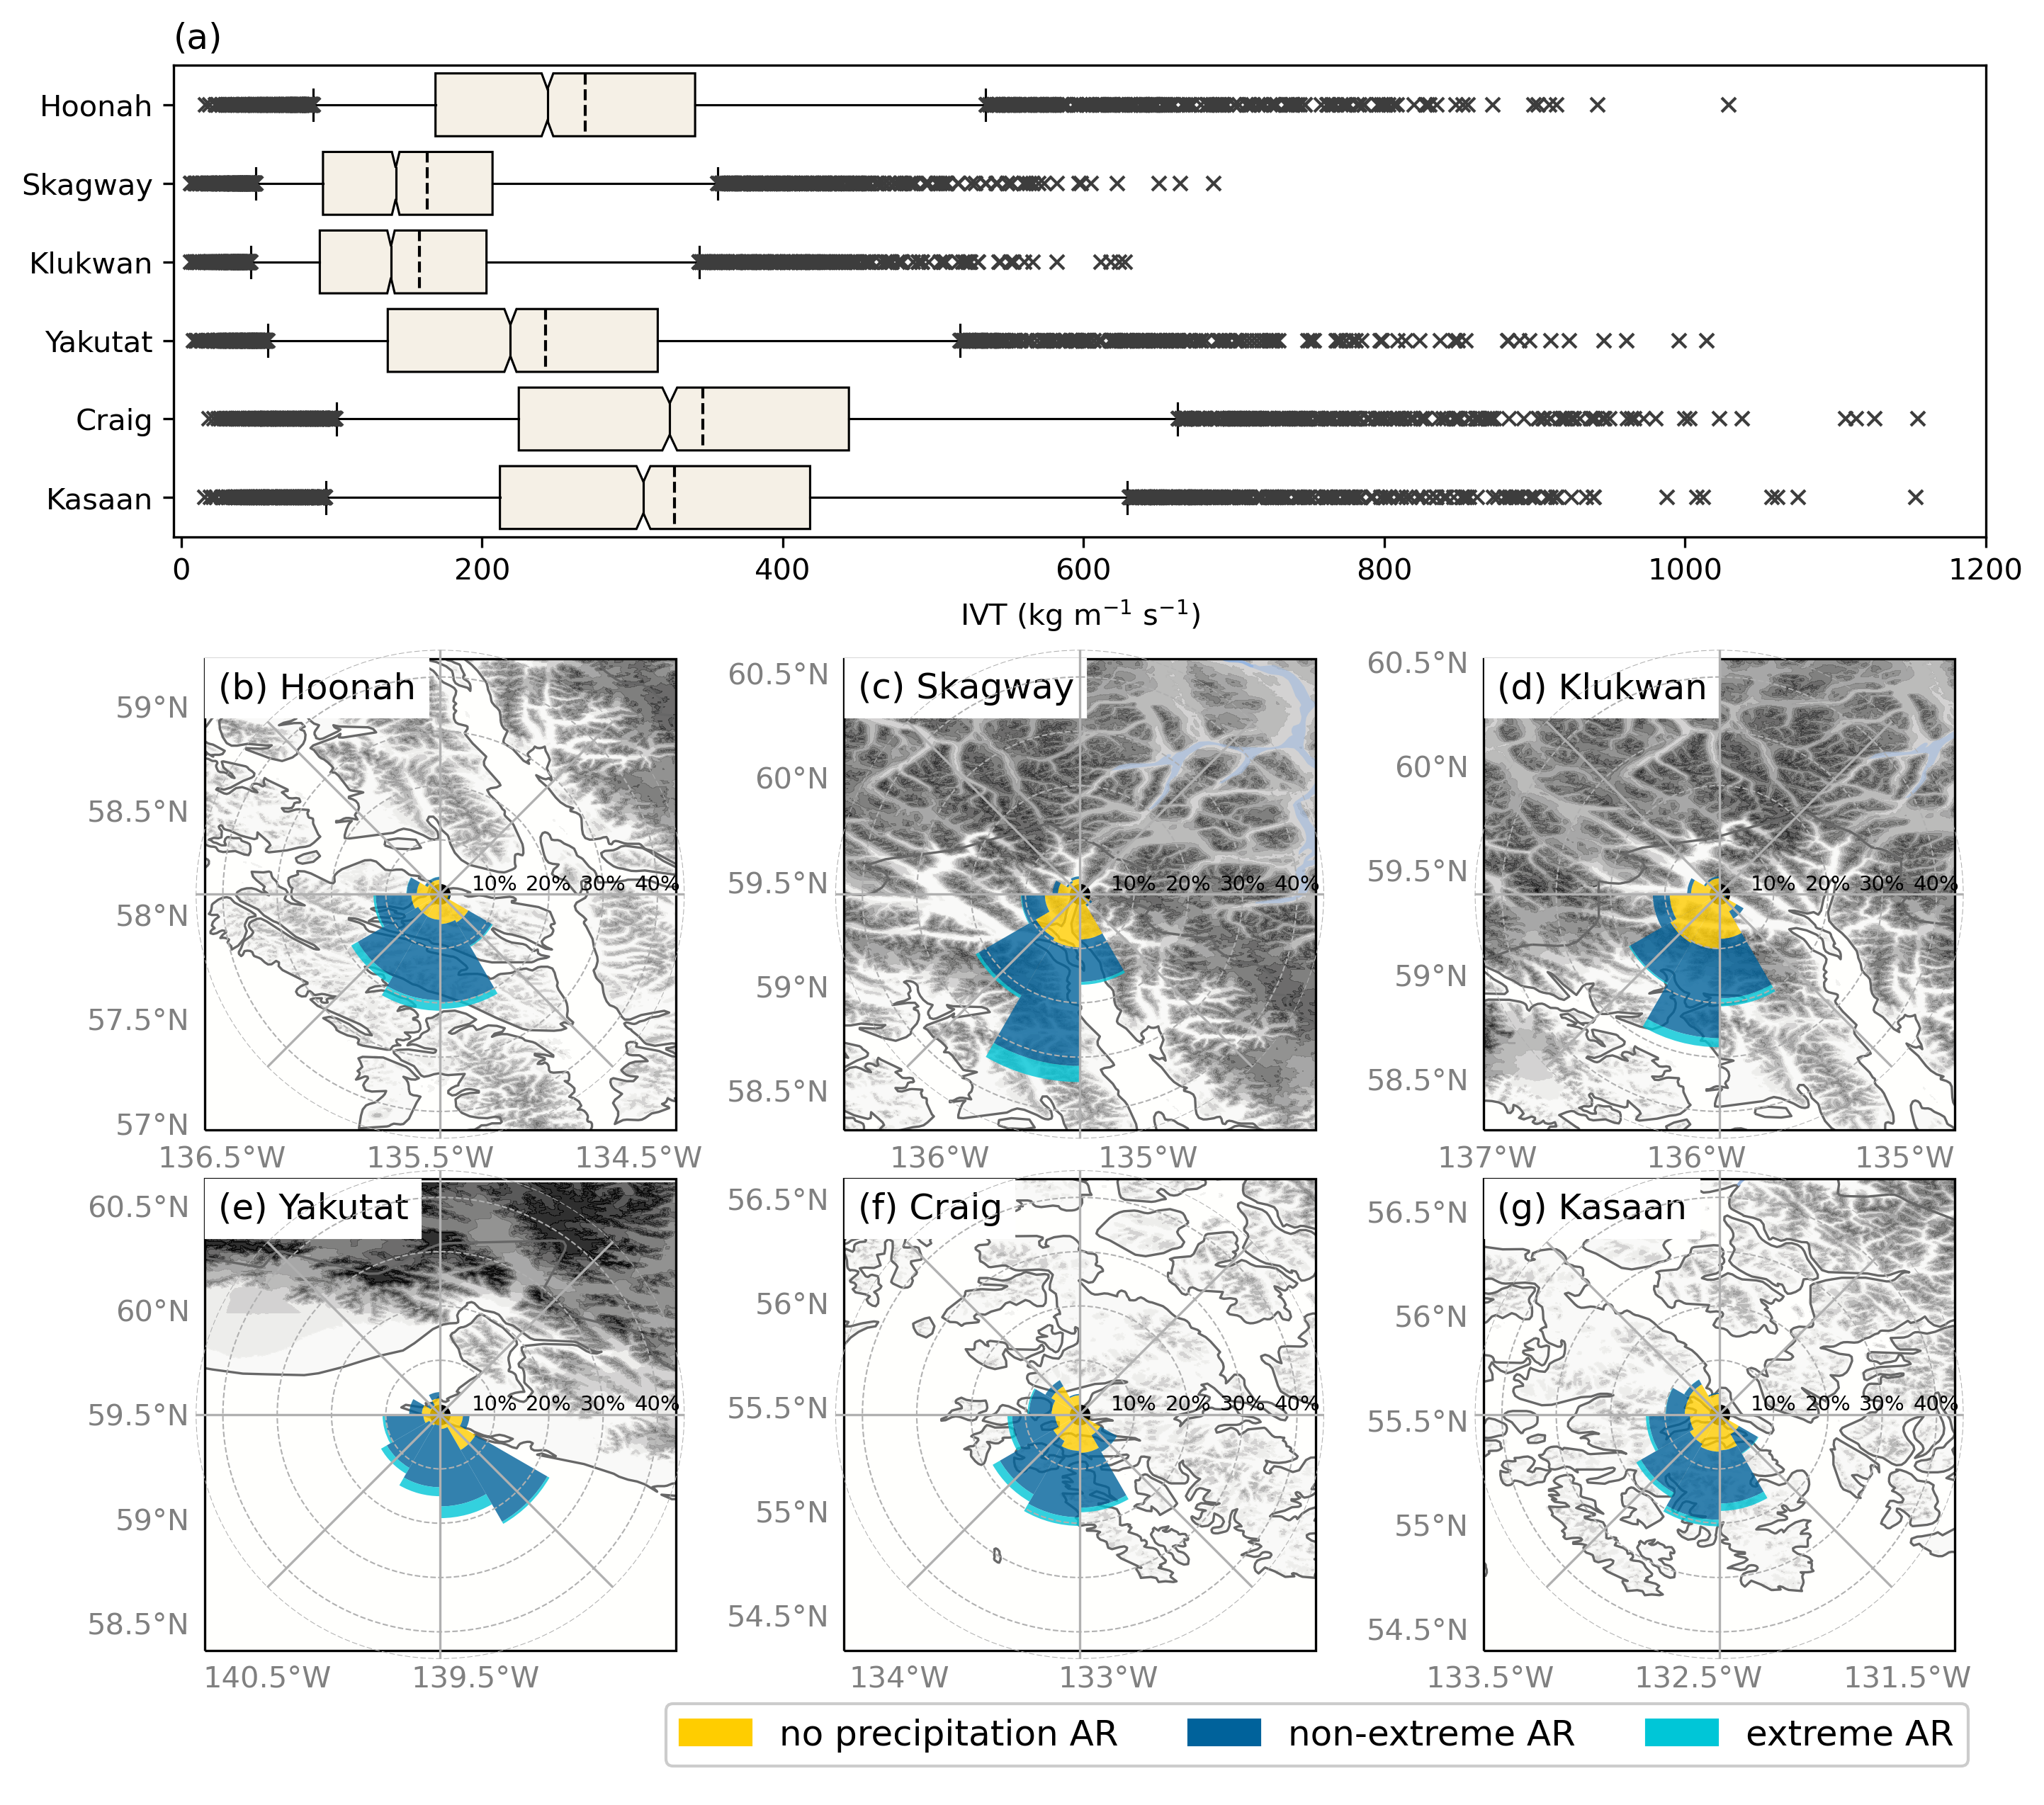

In [10]:
# Create figure
fig = plt.figure(figsize=(11, 10.5))
fig.dpi = 300
fname = path_to_figs + 'extreme-AR_windrose_elev-overlay_{0}'.format(temporal_res)
fmt = 'png'

nrows = 6
ncols = 3

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 0.05, 1, 1, 0.025, 0.05], width_ratios = [1, 1, 1], wspace=0.2, hspace=0.2)
## use gs[rows index, columns index] to access grids

#######################
### BOX AND WHISKER ###
#######################
ax = fig.add_subplot(gs[0, :])
PROPS = {'boxprops':{'facecolor':'#F5F0E6', 'edgecolor':'k'},
         'medianprops':{"color": "k"},
         'whiskerprops':{"color": "k"},
         'capprops':{"color": "k"},
         'flierprops':{"marker": "x"},
         'meanprops':{'c':'k', 'lw':1}}

bplot = sns.boxplot(y="Community", x="IVT", data=df_tidy, whis=[5, 95],
                order=community_lst,
                meanline=True, showmeans=True, 
                notch=True, showcaps=True,
                linewidth=0.75,
                **PROPS)
    
plt.xlim(-5, 1200)
    
ax.set_title('(a)', loc='left')
# ax.annotate(plt_lbl[i], (5, 207), xycoords='axes points', fontsize=12.,
#         backgroundcolor='white', zorder=100)

ax.set_xlabel('IVT (kg m$^{-1}$ s$^{-1}$)')
ax.set_ylabel('')

################
### WINDROSE ###
################

rowidx_lst = [2, 2, 2, 3, 3, 3]
colidx_lst = [0, 1, 2, 0, 1, 2]
for k, (rowidx, colidx) in enumerate(zip(rowidx_lst, colidx_lst)):
    ax = fig.add_subplot(gs[rowidx, colidx], projection=mapcrs)
    
    # Set tick/grid locations
    diff = 0.5
    ext = ext_lst[k]
    dx = np.arange(round(ext[0]),round(ext[1])+diff,diff)
    dy = np.arange(round(ext[2]),round(ext[3])+diff,diff)
    
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=True, right_lats=False, bottom_lons=True)
    
    # ## topo with grey-scale cmap
    # cs = ax.pcolormesh(elev.lon, elev.lat, elev.hillshade, rasterized=False, cmap=cmo.gray, shading='auto', transform=datacrs, alpha=0.8)
    clevs = np.arange(250, 3000, 250)
    cs = ax.contourf(elev.lon, elev.lat, elev.elev, transform=datacrs,
                     levels=clevs, cmap=cmo.gray_r, alpha=0.8, extend='both')
    
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)

    # need this to fix transform for windrose location
    transform = datacrs._as_mpl_transform(ax)

    # Plot Location of community pts
    ax.plot(xs[k], ys[k], 'ko', markersize=6, transform=datacrs)

    ## plot windrose overlay
    df = df_lst[k]
    data = df.loc[(df.AR == 1)] # get only AR days
    # data = data.dropna() # remove days where no precipitation
    data = data.fillna(0) ## fill nans with zero
    # set prec bins for each community
    prec_bins = prec_bins_lst[k]
    rose = calc_rose(data, prec_bins, prec_labels, dir_bins, dir_labels)
    print(rose)
        
    bax = build_rose(xs[k], ys[k], ax, 2.3, rose, directions, False, rad_ticks, transform)
    
    titlestring = '({0}) {1}'.format(letter_lst[k+1], community_lst[k])
    ax.text(0.029, 0.973, titlestring, ha='left', va='top', transform=ax.transAxes, fontsize=12., backgroundcolor='white', zorder=110)
    
##Add color bar
cbax = plt.subplot(gs[-1,:]) # colorbar axis
# cmap = cmo.rain
# bounds = prec_bins[:]
# norm = mcolors.BoundaryNorm(bounds, cmap.N)
# cb = ColorbarBase(cbax, cmap=cmap,
#                   norm=norm,
#                   boundaries=bounds,
#                   extend='neither',
#                   ticks=bounds,
#                   spacing='proportional',
#                   orientation='horizontal')
# # cb.set_label('precipitation (mm day$^{-1}$)')
# cb.ax.tick_params(labelsize=12)

# create legend (of the 2 classes)
cbax.axis('off')
patch0 = mpatches.Patch(color=ucsd_colors['yellow'], label='no precipitation AR')
patch1 = mpatches.Patch(color=ucsd_colors['blue'], label='non-extreme AR')
patch2 = mpatches.Patch(color=ucsd_colors['aqua'], label='extreme AR')
cbax.legend(handles=[patch0, patch1, patch2], loc='lower right', framealpha=1.0, ncol=3, fontsize=12).set_zorder(200)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)

# Show
plt.show()

Of 4903 total observations, 2663 have less than 2.5019531 mm of precipitation.
prec_bins     <0%  0-95%  >95%
ivtdir_bins                   
0.0          2.92   0.33  0.02
30.0         0.10   0.00  0.00
60.0         0.20   0.00  0.00
90.0         0.49   0.06  0.00
120.0        1.06   0.29  0.00
150.0        3.65   1.53  0.00
180.0        8.24  10.97  1.43
210.0       10.12  16.38  1.67
240.0       10.36   8.57  0.27
270.0        9.12   3.10  0.00
300.0        5.18   0.71  0.00
330.0        2.88   0.35  0.00


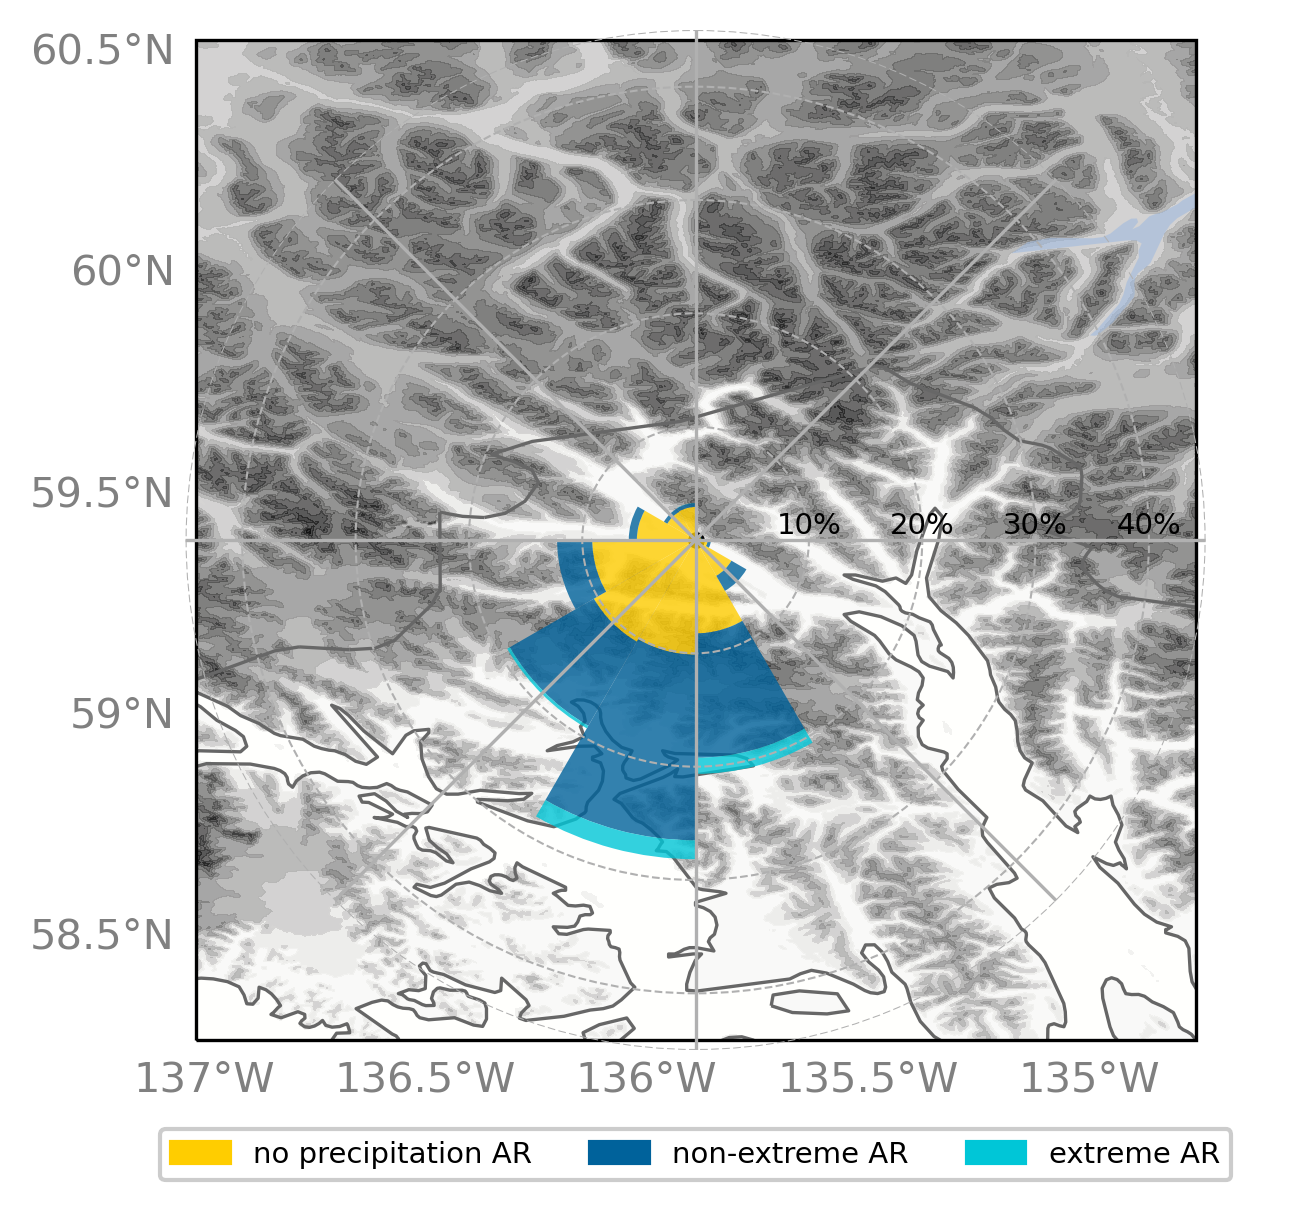

In [11]:
# Create figure
fig = plt.figure(figsize=(5, 5))
fig.dpi = 300
fname = path_to_figs + 'extreme-AR_windrose_elev-overlay_klukwan_poster'
fmt = 'png'

nrows = 2
ncols = 1

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 0.05], width_ratios = [1], wspace=0.2, hspace=0.2)
## use gs[rows index, columns index] to access grids

################
### WINDROSE ###
################

ax = fig.add_subplot(gs[0, 0], projection=mapcrs)

# Set tick/grid locations
diff = 0.5
ext = ext_lst[2]
dx = np.arange(round(ext[0]),round(ext[1])+diff,diff)
dy = np.arange(round(ext[2]),round(ext[3])+diff,diff)

ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=True, right_lats=False, bottom_lons=True)

# ## topo with grey-scale cmap
# cs = ax.pcolormesh(elev.lon, elev.lat, elev.hillshade, rasterized=False, cmap=cmo.gray, shading='auto', transform=datacrs, alpha=0.8)
clevs = np.arange(250, 3000, 250)
cs = ax.contourf(elev.lon, elev.lat, elev.elev, transform=datacrs,
                 levels=clevs, cmap=cmo.gray_r, alpha=0.8, extend='both')

ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# need this to fix transform for windrose location
transform = datacrs._as_mpl_transform(ax)

# Plot Location of community pts
ax.plot(xs[2], ys[2], 'ko', markersize=3, transform=datacrs)

## plot windrose overlay
df = df_lst[2]
data = df.loc[(df.AR == 1)] # get only AR days
# data = data.dropna() # remove days where no precipitation
data = data.fillna(0) ## fill nans with zero
# set prec bins for each community
prec_bins = prec_bins_lst[2]
rose = calc_rose(data, prec_bins, prec_labels, dir_bins, dir_labels)
print(rose)

bax = build_rose(xs[2], ys[2], ax, 3.4, rose, directions, False, rad_ticks, transform)

    
##Add color bar
cbax = plt.subplot(gs[-1,-1]) # colorbar axis

# create legend (of the 2 classes)
cbax.axis('off')
patch0 = mpatches.Patch(color=ucsd_colors['yellow'], label='no precipitation AR')
patch1 = mpatches.Patch(color=ucsd_colors['blue'], label='non-extreme AR')
patch2 = mpatches.Patch(color=ucsd_colors['aqua'], label='extreme AR')
cbax.legend(handles=[patch0, patch1, patch2], loc='lower center', framealpha=1.0, ncol=3, fontsize=7).set_zorder(200)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)

# Show
plt.show()